## **Brain Tumor Classification and Segmentation Using EfficientNet and YOLO**

### Importing Required Libraries

##### pip install -r requirements.txt , install all in cmd prompt

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from warnings import filterwarnings
filterwarnings("ignore")

### Define colors for visualization


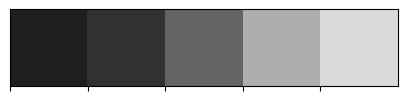

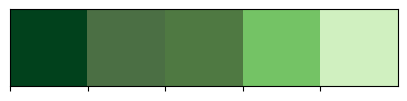

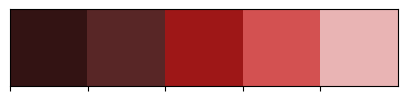

In [14]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

### Define Labels


In [15]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

### **Model 1: EfficientNet-Based Tumor Classification Model**


### Loading and Preparing Data

In [16]:
image_size = 150
X_train, y_train = [], []

### Load Training Data

In [17]:
for label in labels:
    folder_path = os.path.join('DataSet', 'Training', label)
    for image_file in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, image_file))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train = shuffle(X_train, y_train, random_state=101)

100%|██████████| 901/901 [00:04<00:00, 220.86it/s]


### Split Data & Encode Labels

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

y_train = tf.keras.utils.to_categorical([labels.index(label) for label in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(label) for label in y_test])

### Build EfficientNet Model

In [19]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = tf.keras.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

### Train Model

In [20]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7369 - loss: 0.6772
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7381 - loss: 0.6747 - val_accuracy: 0.8571 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9336 - loss: 0.1874
Epoch 2: val_accuracy improved from 0.85714 to 0.91497, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9337 - loss: 0.1872 - val_accuracy: 0.9150 - val_loss: 0.2545 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9477 - loss: 0.1567
Epoch 3: val_accuracy did not improve from 0.91497
83/83 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9478 - loss: 0.1564 - val_accuracy: 0.8367 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9829 - loss: 0.0688
Epoch 4: val_accuracy did not 

### Plot Training Results

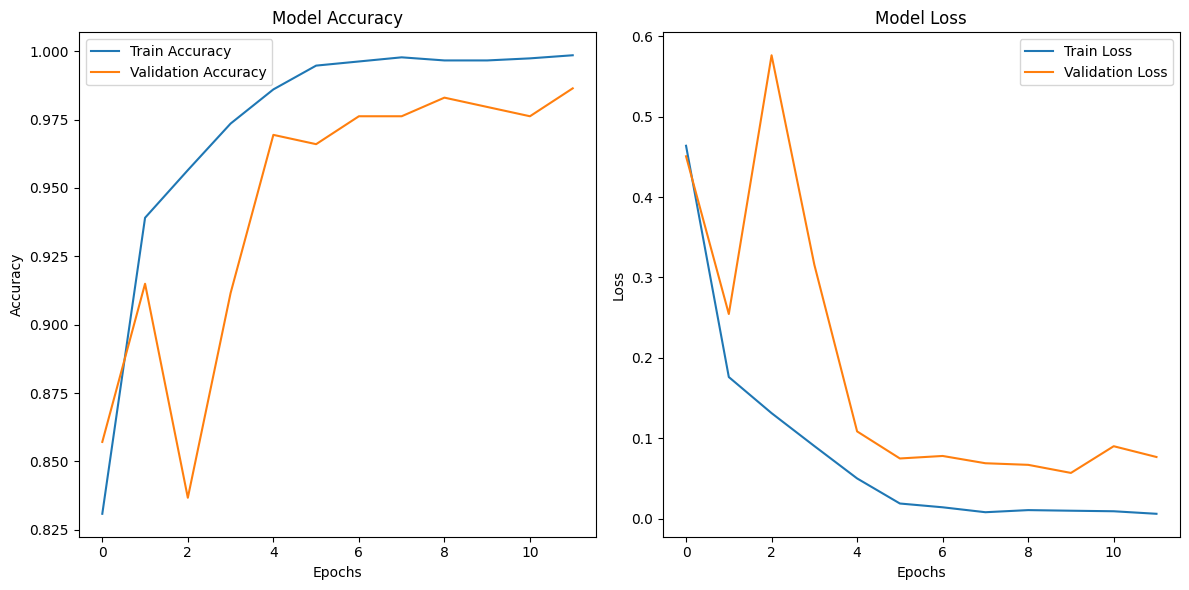

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluate Model, Classification Report and Confusion Matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.97      0.94      0.95        98
        no_tumor       1.00      1.00      1.00        49
meningioma_tumor       0.93      0.97      0.95        93
 pituitary_tumor       0.99      0.98      0.98        87

        accuracy                           0.97       327
       macro avg       0.97      0.97      0.97       327
    weighted avg       0.97      0.97      0.97       327



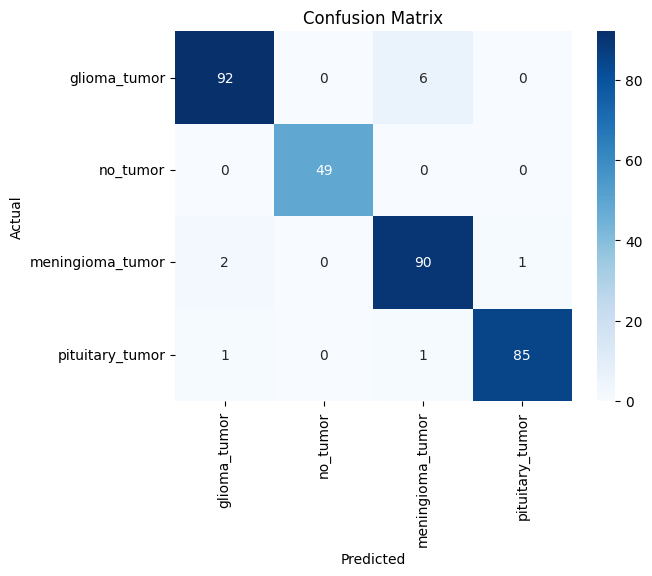

In [22]:
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, pred_classes, target_names=labels))
cm = confusion_matrix(y_test_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Saving the Model

In [ ]:
model.save("models/classification_model.h5")

### Visualize Sample Predictions

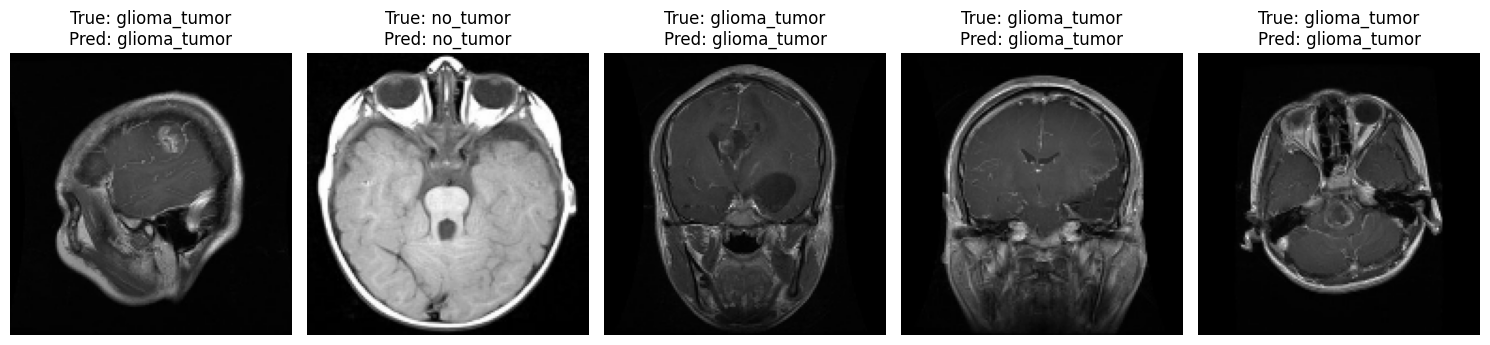

In [23]:
def visualize_predictions(X, y_true, y_pred, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = labels[np.argmax(y_true[idx])]
        pred_label = labels[np.argmax(y_pred[idx])]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, pred, labels)

### **Model 2: YOLO-Based Tumor Segmentation Model**

In [13]:
from roboflow import Roboflow
rf = Roboflow(api_key="a7b1JkwHtDpLlkj509uo")
project = rf.workspace("iotseecs").project("brain-tumor-yzzav")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [14]:
class_names = ['tumor']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

### Function to Plot Segmentation Masks on Images

In [15]:
def plot_segmentation(image, polygons, labels):
    h, w, _ = image.shape
    for polygon_num, polygon in enumerate(polygons):
        class_name = class_names[int(labels[polygon_num])]
        color = colors[class_names.index(class_name)]

        # Denormalize the Polygon Points
        points = []
        for i in range(0, len(polygon), 2):
            x = int(float(polygon[i]) * w)
            y = int(float(polygon[i + 1]) * h)
            points.append([x, y])

        points = np.array(points, np.int32).reshape((-1, 1, 2))

### Draw Mask and Class Label


In [16]:
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)
        cv2.fillPoly(image, [points], color=color)
        centroid_x = int(np.mean(points[:, 0, 0]))
        centroid_y = int(np.mean(points[:, 0, 1]))
        cv2.putText(image, class_name, (centroid_x, centroid_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return image

IndentationError: unexpected indent (2992896990.py, line 7)

### Train YOLO Model


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Load YOLO Pretrained Model
model.train(
    data="BRAIN-TUMOR-1/data.yaml",
    epochs=20,
    imgsz=416,
    batch=16,
    half=True
)

### **Final output**

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model # type: ignore
from ultralytics import YOLO
from IPython.display import display
import ipywidgets as widgets
import io
import shutil

# Load the classification model
try:
    classification_model = load_model('models/model.h5')
    print("Classification model loaded successfully.")
except Exception as e:
    print(f"Error loading classification model: {e}")

# Load the segmentation model
try:
    segmentation_model = YOLO("models/best.pt")
    print("Segmentation model loaded successfully.")
except Exception as e:
    print(f"Error loading segmentation model: {e}")

# Create temporary directories for uploads and segmentation results
UPLOAD_FOLDER = 'temp/uploads'
SEGMENTATION_FOLDER = 'temp/segmentation_results'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(SEGMENTATION_FOLDER, exist_ok=True)

# Global variable to store the uploaded file path
uploaded_file_path = None

# Classification function
def classify_image(image_data):
    try:
        img = Image.open(io.BytesIO(image_data))
        img_resized = cv2.resize(np.array(img), (150, 150))
        img_reshaped = img_resized.reshape(1, 150, 150, 3)
        prediction = classification_model.predict(img_reshaped)
        class_index = np.argmax(prediction, axis=1)[0]
        classes = ['Glioma Tumor', 'No Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
        return classes[class_index]
    except Exception as e:
        return f"Classification Error: {str(e)}"

# Segmentation function
def segment_image(image_path):
    try:
        results = segmentation_model(image_path, save=True)
        output_dir = "runs/segment/predict"
        segmented_image_path = os.path.join(output_dir, os.path.basename(image_path))
        
        if os.path.exists(segmented_image_path):
            final_path = os.path.join(SEGMENTATION_FOLDER, os.path.basename(image_path))
            shutil.move(segmented_image_path, final_path)
            return final_path
        else:
            return f"Error: Segmented image not found in {output_dir}"
    except Exception as e:
        return f"Segmentation Error: {str(e)}"

# Create widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
predict_button = widgets.Button(description="Predict", button_style='success')
classification_output = widgets.Output()
segmentation_output = widgets.Output()

# Callback for handling image uploads
def handle_upload(change):
    global uploaded_file_path
    classification_output.clear_output()
    segmentation_output.clear_output()

    # Ensure a file is uploaded
    uploaded_file = upload_button.value
    if not uploaded_file:
        with classification_output:
            print("No file uploaded. Please upload an image first.")
        return
    
    # Handle file data dynamically
    try:
        file_info = list(uploaded_file.values())[0] if isinstance(uploaded_file, dict) else uploaded_file[0]
        file_data = file_info['content']
        file_name = file_info.get('name', 'uploaded_image.jpg')  # Default name if 'name' is unavailable
        uploaded_file_path = os.path.join(UPLOAD_FOLDER, file_name)

        with open(uploaded_file_path, 'wb') as f:
            f.write(file_data)
        with classification_output:
            print("Image uploaded successfully. Click 'Predict' to process.")
            display(Image.open(io.BytesIO(file_data)))
    except Exception as e:
        with classification_output:
            print(f"Error handling upload: {e}")

# Callback for handling predictions
def handle_predict(change):
    if uploaded_file_path is None:
        with classification_output:
            classification_output.clear_output()
            print("Please upload an image first.")
        return

    with classification_output:
        classification_output.clear_output()
        print("Processing image for classification...")
    with segmentation_output:
        segmentation_output.clear_output()
        print("Processing image for segmentation...")

    # Perform classification
    with open(uploaded_file_path, 'rb') as f:
        file_data = f.read()
    classification_result = classify_image(file_data)
    with classification_output:
        classification_output.clear_output()
        print(f"Classification Result: {classification_result}")

    # Perform segmentation
    segmented_path = segment_image(uploaded_file_path)
    with segmentation_output:
        segmentation_output.clear_output()
        if os.path.exists(segmented_path):
            print("Segmentation completed. Result displayed below:")
            display(Image.open(segmented_path))
        else:
            print(segmented_path)

# Attach callbacks
upload_button.observe(handle_upload, names='value')
predict_button.on_click(handle_predict)

# Display the interface
display(widgets.VBox([
    widgets.Label("Upload an Image for Classification and Segmentation:"),
    upload_button,
    predict_button,
    widgets.Label("Classification Result:"),
    classification_output,
    widgets.Label("Segmentation Result:"),
    segmentation_output
]))


Classification model loaded successfully.
Segmentation model loaded successfully.
